In [5]:
import os

#import matplotlib
#matplotlib.use('MACOSX')
#for some reason if I run these 2 lines - it doesnt plot at all any more.


import numpy as np
import mne
import matplotlib.pyplot as plt
from copy import deepcopy
from mne.time_frequency import tfr_morlet, psd_multitaper, psd_welch


In [6]:
#Load data

#! use relative paths!

kath_raw_file = os.path.join('Katharinas_Data','sub_HT05ND16', '210811', 'mikado-1.fif')                               
raw = mne.io.read_raw_fif(kath_raw_file)

Opening raw data file Katharinas_Data/sub_HT05ND16/210811/mikado-1.fif...
    Read a total of 8 projection items:
        magn8_iasoff_68deg.fif : PCA-v1 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v2 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v3 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v4 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v5 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v6 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v7 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v8 (1 x 306)  idle
    Range : 1809000 ... 3375999 =   1809.000 ...  3375.999 secs
Ready.
Opening raw data file /Users/jenya/Local Storage/Job Uni Rieger lab/MEG QC code/Katharinas_Data/sub_HT05ND16/210811/mikado-2.fif...


/var/folders/h2/khhmb4p510vg63hbv0qkftt80000gs/T/ipykernel_21398/519485196.py:6: RuntimeWarning: This filename (Katharinas_Data/sub_HT05ND16/210811/mikado-1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(kath_raw_file)


    Read a total of 8 projection items:
        magn8_iasoff_68deg.fif : PCA-v1 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v2 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v3 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v4 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v5 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v6 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v7 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v8 (1 x 306)  idle
    Range : 3376000 ... 4942999 =   3376.000 ...  4942.999 secs
Ready.
Opening raw data file /Users/jenya/Local Storage/Job Uni Rieger lab/MEG QC code/Katharinas_Data/sub_HT05ND16/210811/mikado-3.fif...
    Read a total of 8 projection items:
        magn8_iasoff_68deg.fif : PCA-v1 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v2 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v3 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v4 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v5 (1 x 

In [32]:
#Filter the data

def filtering_data(data=None,l_freq=None, h_freq=None, method='iir'):
    # Filtering the data. Recommended: 1-100Hz bandpass or 0.5-100 Hz - better for frequency spectrum

    # method='iir' - I m using here the Butterworth filter similar to filtfilt in matlab, like we  
    # did in the course with eeg data. such filter creates no time shift, since it filters forward and backward.
    # But we might use a different filter as well. I dont know if this one is the best possible option.

    #Data has to be loaded into mememory before filetering:
    data.load_data(verbose=True)
    raw_bandpass = data.copy()
    raw_bandpass.filter(l_freq=l_freq, h_freq=h_freq, picks='meg', method=method, iir_params=None)

    return(raw_bandpass)


In [36]:
#try

filtered_d=filtering_data(data=raw,l_freq=1, h_freq=100, method='iir')

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 100.00 Hz: -6.02, -6.02 dB



In [10]:
#%% RMSE - general function to use in other functions
#STD CALCULATION IS MUCH LESS COdE BUT TAKES LONGER THAN RMSE

def RMSE(data_mags=None, data_grads=None):

    # https://stackoverflow.com/questions/17197492/is-there-a-library-function-for-root-mean-square-error-rmse-in-python

    from sklearn.metrics import mean_squared_error

    #Magnitometers:
    y_actual_mags=data_mags
    y_predicted_mags=data_mags.mean(axis=1)

    rmse_mags = np.zeros(len(y_predicted_mags)) #RMSE of all magnetometers

    for i in range(len(y_predicted_mags)):
        y_predicted_vec_mags=np.ones(len(y_actual_mags[0]))*y_predicted_mags[i]
        rmse_mags[i] = mean_squared_error(y_actual_mags[i, :], y_predicted_vec_mags, squared=False)


    #Gradiometers:
    y_actual_grads=data_grads
    y_predicted_grads=data_grads.mean(axis=1)

    rmse_grads = np.zeros(len(y_predicted_grads)) #RMSE of all gradiometers

    for i in range(len(y_predicted_grads)):
        y_predicted_vec_grads=np.ones(len(y_actual_grads[0]))*y_predicted_grads[i]
        rmse_grads[i] = mean_squared_error(y_actual_grads[i, :], y_predicted_vec_grads, squared=False)

    return(rmse_mags, rmse_grads)


In [11]:
# Root mean squared error calculation (or STD - same result) over all data:

def RMSE_meg_all(data=None, std_lvl=1): #, min_duration_event=1, epoch_tmin=-0.2, epoch_tmax=1):
    #give path to directory and then it should auto find the data file when bids compliant.

    #Separate mags and grads:
    mags = [(chs['ch_name'], i) for i, chs in enumerate(data.info['chs']) if str(chs['unit']).endswith('UNIT_T)')]
    grads = [(chs['ch_name'], i) for i, chs in enumerate(data.info['chs']) if str(chs['unit']).endswith('UNIT_T_M)')]
  

    # Separate data for mags and grads in 2 arrays.
    selected_mags = [item[1] for item in mags]
    selected_grads = [item[1] for item in grads]
    data_mags, times = data[selected_mags, :]  
    data_grads, times = data[selected_grads, :]  

    # %% Calculate STD or RMSE of each channel

    #Calculate RMSE for each channel (separated mags and grads) - for the entire time duration:
    std_mags, std_grads = RMSE(data_mags=data_mags, data_grads=data_grads)

    #STD (if wanna use insted of RMSE. it will exactly replace the RMSE function above):
    #std_mags=np.std(data_mags, axis=1) #calculate std of all magnetometers (along second dimantion)
    #std_grads=np.std(data_grads, axis=1) #calculate std of all gradiometers (along second dimantion)


    # Check if channel data is within 1 std over all channels.
    # COMMENT: can use -3 to 3 (or other number) std istead of -1/+1 std, but this can adjusted later. 
    # 1 std is too narrow, gives way too many bad channels.

    std_std_mags=np.std(std_mags)
    std_std_grads=np.std(std_grads)

    mean_std_mags=np.mean(std_mags)
    mean_std_grads=np.mean(std_grads)

    ch_large_std_mags= np.where(std_mags > mean_std_mags+std_lvl*std_std_mags) # | std_mags < mean_std_magn-std_std_mags)
    ch_large_std_grads= np.where(std_grads > mean_std_grads+std_lvl*std_std_grads) # | std_grads < mean_std_grad-std_std_grads)

    ch_small_std_mags= np.where(std_mags < mean_std_mags-std_lvl*std_std_mags)
    ch_small_std_grads= np.where(std_grads < mean_std_grads-std_lvl*std_std_grads)


    magn_channel_big_std=np.array(mags)[ch_large_std_mags[0]]
    grad_channel_big_std=np.array(grads)[ch_large_std_grads[0]]

    magn_channel_small_std=np.array(mags)[ch_small_std_mags[0]]
    grad_channel_small_std=np.array(grads)[ch_small_std_grads[0]]

    print('Magnetometers with high STD: ', magn_channel_big_std)
    print('Gradiometers with high STD: ',grad_channel_big_std)

    print('Magnetometers with low STD: ', magn_channel_small_std)
    print('Gradiometers with low STD: ',grad_channel_small_std)


    #PLOT CHANNELS WITH HIGH-LOW STD. DO WE WANT THAT?
    from matplotlib import pyplot as plt
    #%matplotlib qt
    #%matplotlib inline

    fig, (ax1, ax2) = plt.subplots(2)
    fig.suptitle('STDs')
    ax1.plot(list(range(1, len(std_mags)+1)), std_mags)
    ax1.plot(list(range(1, len(std_mags)+1)), [mean_std_mags]*len(std_mags))
    ax1.plot(list(range(1, len(std_mags)+1)), [mean_std_mags-std_lvl*std_std_mags]*len(std_mags))
    ax1.plot(list(range(1, len(std_mags)+1)), [mean_std_mags+std_lvl*std_std_mags]*len(std_mags))
    ax1.set(xlabel='Magnetometer', ylabel='STD')

    ax2.plot(list(range(1, len(std_grads)+1)), std_grads)
    ax2.plot(list(range(1, len(std_grads)+1)), [mean_std_grads]*len(std_grads))
    ax2.plot(list(range(1, len(std_grads)+1)), [mean_std_grads-std_lvl*std_std_grads]*len(std_grads))
    ax2.plot(list(range(1, len(std_grads)+1)), [mean_std_grads+std_lvl*std_std_grads]*len(std_grads))
    ax2.set(xlabel='Gradiometer', ylabel='STD')

    plt.show()


    #Return the channel names with STD over the set STD level and under the set negative STD level.
    return(magn_channel_big_std, grad_channel_big_std, magn_channel_small_std, grad_channel_small_std)


    #CAN ADD OPTIONAL PLOTTING OF SOME CHANNELS WITH HIGH/LOW STD. DO WE BEED THAT?
    #WHAT DO WE WANT TO GIVE AS OUTPUT HERE? NEED PLOTS, NEED LIST OF CHANNELS?

Magnetometers with high STD:  [['MEG0221' '26']
 ['MEG0231' '29']
 ['MEG0341' '44']
 ['MEG0511' '59']
 ['MEG0541' '68']
 ['MEG0611' '71']
 ['MEG0641' '80']
 ['MEG0741' '92']
 ['MEG1031' '119']
 ['MEG1521' '176']
 ['MEG1711' '197']
 ['MEG1841' '218']
 ['MEG1941' '230']
 ['MEG2231' '263']
 ['MEG2321' '272']
 ['MEG2331' '275']
 ['MEG2431' '287']
 ['MEG2511' '293']
 ['MEG2631' '311']]
Gradiometers with high STD:  [['MEG0112' '12']
 ['MEG0132' '18']
 ['MEG0142' '21']
 ['MEG0143' '22']
 ['MEG0213' '25']
 ['MEG0223' '28']
 ['MEG0542' '69']
 ['MEG0713' '85']
 ['MEG0743' '94']
 ['MEG0933' '109']
 ['MEG0942' '111']
 ['MEG1012' '114']
 ['MEG1022' '117']
 ['MEG1032' '120']
 ['MEG1042' '123']
 ['MEG1043' '124']
 ['MEG1232' '144']
 ['MEG1243' '148']
 ['MEG1412' '162']
 ['MEG1422' '165']
 ['MEG1442' '171']
 ['MEG1512' '174']
 ['MEG1532' '180']
 ['MEG1533' '181']
 ['MEG1732' '204']
 ['MEG1822' '213']
 ['MEG2032' '240']
 ['MEG2112' '246']
 ['MEG2143' '256']
 ['MEG2242' '267']
 ['MEG2313' '271']
 ['MEG2

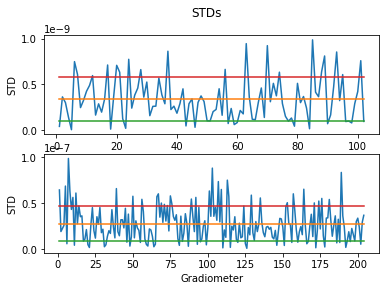

(array([['MEG0221', '26'],
        ['MEG0231', '29'],
        ['MEG0341', '44'],
        ['MEG0511', '59'],
        ['MEG0541', '68'],
        ['MEG0611', '71'],
        ['MEG0641', '80'],
        ['MEG0741', '92'],
        ['MEG1031', '119'],
        ['MEG1521', '176'],
        ['MEG1711', '197'],
        ['MEG1841', '218'],
        ['MEG1941', '230'],
        ['MEG2231', '263'],
        ['MEG2321', '272'],
        ['MEG2331', '275'],
        ['MEG2431', '287'],
        ['MEG2511', '293'],
        ['MEG2631', '311']], dtype='<U21'),
 array([['MEG0112', '12'],
        ['MEG0132', '18'],
        ['MEG0142', '21'],
        ['MEG0143', '22'],
        ['MEG0213', '25'],
        ['MEG0223', '28'],
        ['MEG0542', '69'],
        ['MEG0713', '85'],
        ['MEG0743', '94'],
        ['MEG0933', '109'],
        ['MEG0942', '111'],
        ['MEG1012', '114'],
        ['MEG1022', '117'],
        ['MEG1032', '120'],
        ['MEG1042', '123'],
        ['MEG1043', '124'],
        ['MEG1232', '

In [12]:
#Try:

RMSE_meg_all(data=filtered_d, std_lvl=1)

In [28]:
# STD over epochs. 

def RMSE_meg_epoch(data=None, stim_channel='STI101', std_lvl=1, min_duration_event=1.2, epoch_tmin=-0.2, epoch_tmax=1):
    #stim_channel name is users input. but we can also let mne find it itself if 'None' is set? mne seems to have such function.

    #Find events and epochs:
    events = mne.find_events(data, stim_channel=stim_channel, min_duration=min_duration_event)
    epochs = mne.Epochs(data, events, tmin=epoch_tmin, tmax=epoch_tmax, preload=True, baseline = None) #, event_id=event_dict, reject=reject_criteria)

    #Present epochs as data frame:
    df = epochs.to_data_frame(time_format=None, scalings=dict(mag=1, grad=1))


    # 1) Loop over the epochs of each channel and check for every separate magn and grad and calculate std
    import pandas as pd
    eps=list(range(0,len(events))) #list of epoch numbers

    #Separate mags and grads:
    mags = [(chs['ch_name'], i) for i, chs in enumerate(data.info['chs']) if str(chs['unit']).endswith('UNIT_T)')]
    grads = [(chs['ch_name'], i) for i, chs in enumerate(data.info['chs']) if str(chs['unit']).endswith('UNIT_T_M)')]
    
    mags_names = [mag[0] for mag in mags]
    grads_names = [grad[0] for grad in grads]

    combined_names = {"mags": mags_names, "grads": grads_names}

    dict_mags = {}
    dict_grads = {}

    for ep in eps: #loop over each epoch
        rows_for_ep = [row for row in df.iloc if row.epoch == ep]

        std_epoch = {"mags": [], "grads": []}

        for key_of_list in combined_names: #loop over mags, then grads

            for ch_name in combined_names[key_of_list]: #loop over channel names
                
                data_ch_epoch = [row_m[ch_name] for row_m in rows_for_ep]

                std_ch_ep = np.std(data_ch_epoch)   #HERE CAN ALSO REPLACE STD WITH RMSE CALCULATION FOR SPEED!

                std_epoch[key_of_list].append(std_ch_ep)

        dict_mags[ep] = std_epoch["mags"]
        dict_grads[ep] = std_epoch["grads"]

    df_std_mags = pd.DataFrame(dict_mags, index=mags_names)
    df_std_grads = pd.DataFrame(dict_grads, index=grads_names)


    # Create csv file  for the user:

    #Using relative path:
    file_dir = os.path.dirname(os.path.abspath('Funks.ipynb')) 
    csv_folder = 'csv files' #THE FOLDER HAS TO BE CREATED ALREADY!
    file_path_m = os.path.join(file_dir, csv_folder, 'std_mags_per_epoch.csv')
    df_std_mags.to_csv(file_path_m)

    file_path_g = os.path.join(file_dir, csv_folder, 'std_grads_per_epoch.csv')
    df_std_grads.to_csv(file_path_g)

    #Absolute path:
    #df_std_mags.to_csv('/Users/jenya/Local Storage/Job Uni Rieger lab/MEG QC code/std_mags_per_epoch.csv')  #HOW TO MAKE RELATIVE PATH 
    #df_std_grads.to_csv('/Users/jenya/Local Storage/Job Uni Rieger lab/MEG QC code/std_grads_per_epoch.csv')


    # 2) Check (which epochs for which channel) are over 1STD (or 2, 3, ets STDs) for (this epoch for all channels)

    #Find what is 1 std over all channels per 1 epoch:
    std_std_mags_per_epoch=[]
    std_std_grads_per_epoch=[]
    mean_std_mags_per_epoch=[]
    mean_std_grads_per_epoch=[]

    for ep in eps: #goes over each epoch
        std_std_mags_per_epoch.append(np.std(df_std_mags.iloc[:, ep])) #std of stds of all channels of every single epoch
        std_std_grads_per_epoch.append(np.std(df_std_grads.iloc[:, ep]))

        mean_std_mags_per_epoch.append(np.mean(df_std_mags.iloc[:, ep])) #mean of stds of all channels of every single epoch
        mean_std_grads_per_epoch.append(np.mean(df_std_grads.iloc[:, ep]))


    df_ch_ep_large_std_mags=df_std_mags
    df_ch_ep_large_std_grads=df_std_grads

    df_ch_ep_small_std_mags=df_std_mags
    df_ch_ep_small_std_grads=df_std_grads

    #Now see which channles in epoch are over 1 std or under -1 std:
    for ep in eps: #goes over each epoch   
        df_ch_ep_large_std_mags.iloc[:,ep] = df_std_mags.iloc[:,ep] > mean_std_mags_per_epoch[ep]+std_lvl*std_std_mags_per_epoch[ep] #magnetometers
        df_ch_ep_large_std_grads.iloc[:,ep] = df_std_grads.iloc[:,ep] > mean_std_grads_per_epoch[ep]+std_lvl*std_std_grads_per_epoch[ep] #gradiometers

        df_ch_ep_small_std_mags.iloc[:,ep] = df_std_mags.iloc[:,ep] < mean_std_mags_per_epoch[ep]-std_lvl*std_std_mags_per_epoch[ep] #magnetometers
        df_ch_ep_small_std_grads.iloc[:,ep] = df_std_grads.iloc[:,ep] < mean_std_grads_per_epoch[ep]-std_lvl*std_std_grads_per_epoch[ep] #gradiometers


    #Make csv for the user:

    #abs path:
    #df_ch_ep_large_std_mags.to_csv('/Users/jenya/Local Storage/Job Uni Rieger lab/MEG QC code/large_std_mags.csv')
    #df_ch_ep_large_std_grads.to_csv('/Users/jenya/Local Storage/Job Uni Rieger lab/MEG QC code/large_std_grads.csv')

    #Relative path:
    file_path_m_large = os.path.join(file_dir, csv_folder, 'Large_std_mags_per_epoch.csv')
    df_ch_ep_large_std_mags.to_csv(file_path_m_large)

    file_path_g_large = os.path.join(file_dir, csv_folder, 'Large_std_grads_per_epoch.csv')
    df_ch_ep_large_std_grads.to_csv(file_path_g_large)

    file_path_m_small = os.path.join(file_dir, csv_folder, 'Small_std_mags_per_epoch.csv')
    df_ch_ep_small_std_mags.to_csv(file_path_m_small)

    file_path_g_small = os.path.join(file_dir, csv_folder, 'Small_std_grads_per_epoch.csv')
    df_ch_ep_small_std_grads.to_csv(file_path_g_small)

    return(df)


In [34]:
#try

df=RMSE_meg_epoch(data=filtered_d, stim_channel='STI101', std_lvl=1, min_duration_event=1.2, epoch_tmin=-0.2, epoch_tmax=1)

Trigger channel has a non-zero initial value of 18 (consider using initial_event=True to detect this event)
37 events found
Event IDs: [ 9 19 20 21 22]
Not setting metadata
Not setting metadata
37 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 8)
8 projection items activated
Loading data for 37 events and 1201 original time points ...


/var/folders/h2/khhmb4p510vg63hbv0qkftt80000gs/T/ipykernel_21398/1375242293.py:7: RuntimeWarning: Trigger channel contains negative values, using absolute value. If data were acquired on a Neuromag system with STI016 active, consider using uint_cast=True to work around an acquisition bug
  events = mne.find_events(data, stim_channel=stim_channel, min_duration=min_duration_event)


0 bad epochs dropped


In [35]:
df

,time,condition,epoch,IASX+,IASX-,IASY+,IASY-,IASZ+,IASZ-,IAS_DX,...,MEG2622,MEG2623,MEG2631,MEG2632,MEG2633,MEG2641,MEG2642,MEG2643,STI101,SYS201
0,-0.200,19,0,-1.192093e-06,-1.192093e-06,-1.192093e-06,-1.192093e-06,3.893870e-30,1.183126e-29,-1.192093e-06,...,-2.378881e-13,5.026841e-12,8.542806e-14,-3.145492e-12,1.912644e-12,-2.126964e-14,2.968265e-12,-2.189534e-12,18.0,0.0
1,-0.199,19,0,-1.192093e-06,-1.192093e-06,-1.192093e-06,-1.192093e-06,-1.192093e-06,-1.192093e-06,-1.192093e-06,...,-2.566464e-13,4.963734e-12,8.435688e-14,-3.179598e-12,1.849812e-12,-2.153281e-14,2.914556e-12,-2.209996e-12,18.0,0.0
2,-0.198,19,0,-1.192093e-06,-1.192093e-06,-1.192093e-06,-1.192093e-06,-1.192093e-06,-1.192093e-06,-1.192093e-06,...,-2.760911e-13,4.900609e-12,8.329615e-14,-3.212924e-12,1.787378e-12,-2.178249e-14,2.861148e-12,-2.230155e-12,18.0,0.0
3,-0.197,19,0,-1.790822e-29,-1.192093e-06,-5.910833e-30,-3.140031e-30,-1.192093e-06,-1.192093e-06,-3.718041e-30,...,-2.962006e-13,4.837492e-12,8.224588e-14,-3.245459e-12,1.725362e-12,-2.201883e-14,2.808049e-12,-2.250002e-12,18.0,0.0
4,-0.196,19,0,-1.755787e-29,-1.095411e-29,-5.725688e-30,-3.004025e-30,3.580514e-30,1.016097e-29,-3.615257e-30,...,-3.169529e-13,4.774405e-12,8.120606e-14,-3.277194e-12,1.663787e-12,-2.224198e-14,2.755265e-12,-2.269529e-12,18.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44432,0.996,21,36,6.962759e-29,5.155719e-29,1.475776e-29,1.070682e-29,2.262775e-30,-5.661480e-30,-1.119853e-30,...,-2.717885e-13,-5.052579e-12,-7.114890e-14,-5.010486e-13,-5.574952e-12,4.886081e-14,-2.315376e-12,-2.118873e-13,21.0,0.0
44433,0.997,21,36,7.031782e-29,5.228864e-29,1.486843e-29,1.090652e-29,-1.192093e-06,-1.192093e-06,-1.092110e-30,...,-3.529010e-13,-5.140834e-12,-7.157682e-14,-5.422911e-13,-5.649329e-12,4.981500e-14,-2.331956e-12,-2.920576e-13,21.0,0.0
44434,0.998,21,36,7.099839e-29,-1.192093e-06,-1.192093e-06,-1.192093e-06,-1.192093e-06,-1.192093e-06,-1.064157e-30,...,-4.338004e-13,-5.228862e-12,-7.200964e-14,-5.831340e-13,-5.723376e-12,5.075581e-14,-2.348345e-12,-3.716895e-13,21.0,0.0
44435,0.999,21,36,7.166904e-29,-1.192093e-06,-1.192093e-06,-1.192093e-06,-1.192093e-06,-1.192093e-06,-1.036000e-30,...,-5.144610e-13,-5.316624e-12,-7.244703e-14,-6.235624e-13,-5.797057e-12,5.168282e-14,-2.364533e-12,-4.507598e-13,21.0,0.0
